In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.regression import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

storeData = pd.read_csv("Walmart.csv",index_col="Store")
print(storeData.head())

             Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Store                                                                    
1      05-02-2010    1643690.90             0        42.31       2.572   
1      12-02-2010    1641957.44             1        38.51       2.548   
1      19-02-2010    1611968.17             0        39.93       2.514   
1      26-02-2010    1409727.59             0        46.63       2.561   
1      05-03-2010    1554806.68             0        46.50       2.625   

              CPI  Unemployment  
Store                            
1      211.096358         8.106  
1      211.242170         8.106  
1      211.289143         8.106  
1      211.319643         8.106  
1      211.350143         8.106  


By printing the first five of rows of the data, we are able to determine the dependent and independent variables. Dependent variable is the Weekly_Sales. Independent variables consist of the Holiday_Flag, Temperature, Fuel_Price, CPI and Unemployment.

In [ ]:
storeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


The data type of the Date (object) and Holiday_Flag (int) columns are incorrect. Therefore, the code below converts Date to type Date and Holiday_Flag to type Boolean.

In [ ]:
storeData["Date"] = pd.to_datetime(storeData["Date"],format="%d-%m-%Y")
storeData["Holiday_Flag"] = storeData["Holiday_Flag"].astype("bool")
storeData["Store"] = storeData["Store"].astype("category")
storeData.info()
storeData.describe()

dataRowNum = int(len(storeData.index)/45)
print("\nTotal number of stores: 45")
print("Number of data row for each store:", dataRowNum)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   category      
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   bool          
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: bool(1), category(1), datetime64[ns](1), float64(5)
memory usage: 315.7 KB

Total number of stores: 45
Number of data row for each store: 143


We can now see that the data type of Date and Holiday_Flag have been corrected. In addition, for each store, there are 143 rows of data with 6435 total rows of data in the CSV file. 

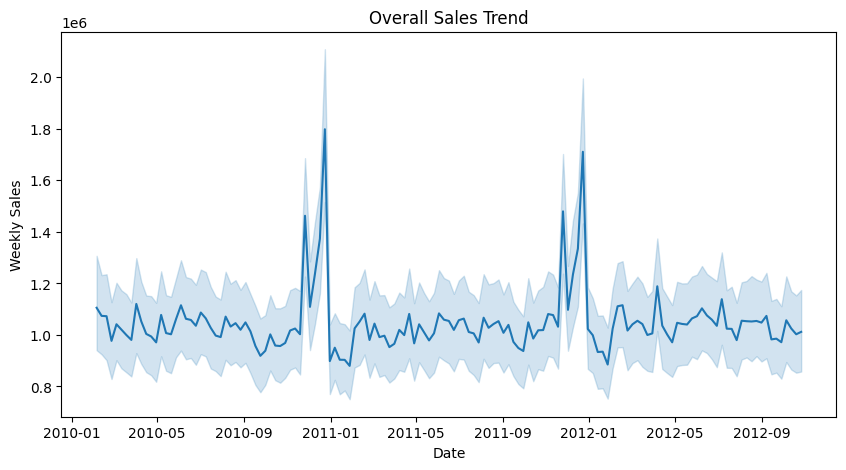

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Overall Sales Trend")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
sns.lineplot(x=storeData["Date"],y=storeData["Weekly_Sales"])
plt.show()

By plotting the overall sales trend, highest weekly sales occur during November and December, when it's around Christmas season. The sales trend for the other months are generally the same and does not show a significant trend.

Text(0, 0.5, 'Monthly Sales')

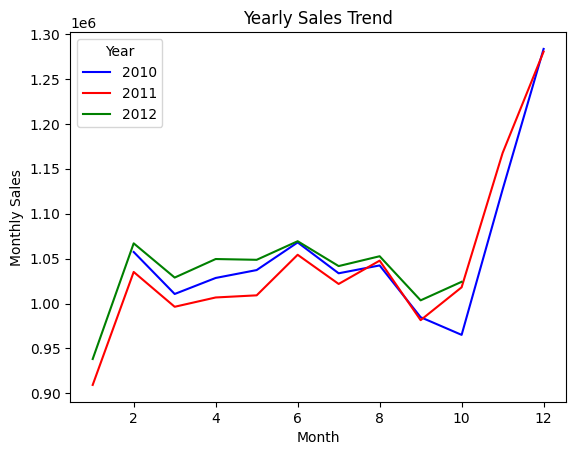

In [ ]:
storeData["Year"] = storeData["Date"].dt.year
storeData["Month"] = storeData["Date"].dt.month

sns.lineplot(data=storeData,x="Month",y="Weekly_Sales", hue="Year", palette=["b","r","g"],errorbar=None)
plt.title("Yearly Sales Trend")
plt.ylabel("Monthly Sales")


For all three years, the monthly sales trend per year reinforces that weekly sales increase significantly and reach the highest point upon reaching December (Christmas Holiday). After the Christmas Holiday, the weekly sales sharply decline as shown in January. 

In [ ]:
def organizeSalesByStore(data):
  salesByStore = data.groupby("Store").sum(numeric_only=True)
  salesByStore = salesByStore.drop("Year",axis = 1)
  salesByStore = salesByStore.drop("Month",axis = 1)

  salesByStore["Holiday_Flag"] = salesByStore["Holiday_Flag"].div(dataRowNum).round(2)
  salesByStore["Temperature"] = salesByStore["Temperature"].div(dataRowNum).round(2)
  salesByStore["Fuel_Price"] = salesByStore["Fuel_Price"].div(dataRowNum).round(2)
  salesByStore["CPI"] = salesByStore["CPI"].div(dataRowNum).round(2)
  salesByStore["Unemployment"] = salesByStore["Unemployment"].div(dataRowNum).round(2)

  salesByStore = salesByStore.rename(columns={"Weekly_Sales":"Total Weekly Sales",\
        "Holiday_Flag":"Holiday Flag", "Temperature":"Average Temperature",\
        "Fuel_Price":"Average Fuel Price", "CPI":"Average CPI", "Unemployment":\
        "Average Unemployment Rate"})

  return salesByStore

salesByStore = organizeSalesByStore(storeData)
print(salesByStore.head())

       Total Weekly Sales  Holiday Flag  Average Temperature  \
Store                                                          
1            2.224028e+08          0.07                68.31   
2            2.753824e+08          0.07                68.22   
3            5.758674e+07          0.07                71.43   
4            2.995440e+08          0.07                62.25   
5            4.547569e+07          0.07                69.41   

       Average Fuel Price  Average CPI  Average Unemployment Rate  
Store                                                              
1                    3.22       216.00                       7.61  
2                    3.22       215.65                       7.62  
3                    3.22       219.39                       7.18  
4                    3.22       128.68                       5.96  
5                    3.22       216.57                       6.30  


The code above organizes the sales data by store: total weekly sales per store and the averages of holiday flage, temperature, fuel price, CPI and unemployment rate.

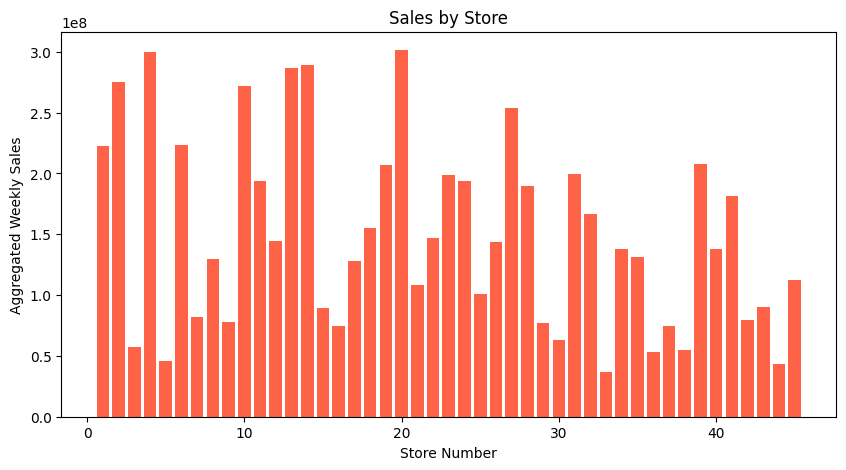

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Aggregated Weekly Sales")
plt.bar(salesByStore.index.tolist(), salesByStore["Total Weekly Sales"],color="Tomato")
plt.show()


The bar graph summarizes the aggregated (total) weekly sales per store. Through the graph, store 20 is the store with the best sales and store 33 is the store with the worst sales. 

In [ ]:
bestStore = salesByStore[salesByStore["Total Weekly Sales"] == salesByStore["Total Weekly Sales"].max()]
worstStore = salesByStore[salesByStore["Total Weekly Sales"] == salesByStore["Total Weekly Sales"].min()]

bestWorstStore = pd.concat([bestStore,worstStore],ignore_index=False)
print(bestWorstStore.head())

       Total Weekly Sales  Holiday Flag  Average Temperature  \
Store                                                          
20           3.013978e+08          0.07                55.45   
33           3.716022e+07          0.07                76.73   

       Average Fuel Price  Average CPI  Average Unemployment Rate  
Store                                                              
20                   3.42       209.04                       7.37  
33                   3.58       128.68                       8.53  


The code above extracts the data rows of the stores with the best (20) and worst (33) weekly sales for analysis below.

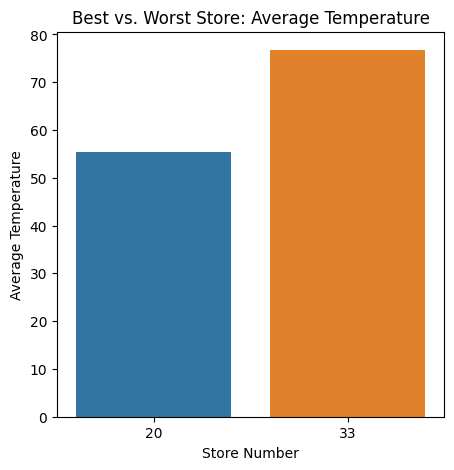

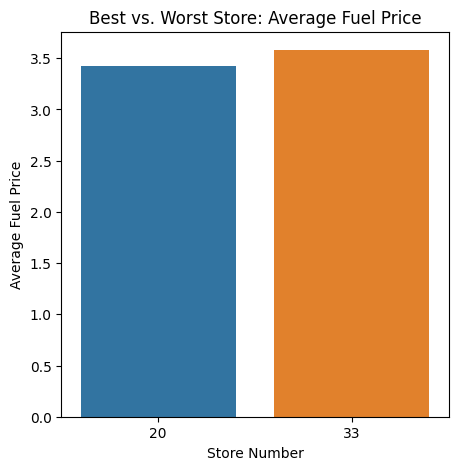

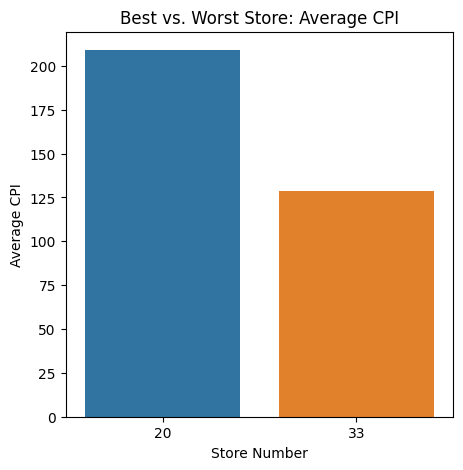

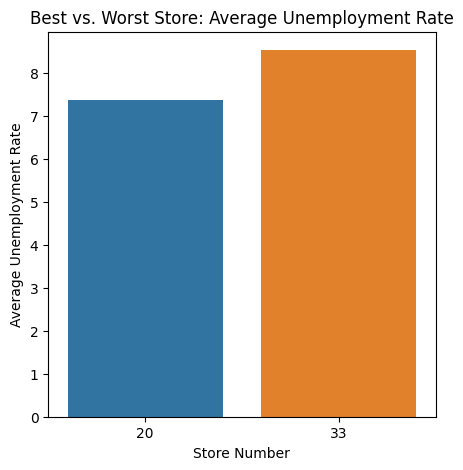

In [ ]:
def compareBestWorst(data,column):
    plt.figure(figsize=(5,5))
    plt.title("Best vs. Worst Store: " + column)
    plt.xlabel("Store Number")
    plt.ylabel(column)
    sns.barplot(x=bestWorstStore.index.tolist(),y=column,data=bestWorstStore)
    plt.show()

compareBestWorst(bestWorstStore, "Average Temperature")
compareBestWorst(bestWorstStore, "Average Fuel Price")
compareBestWorst(bestWorstStore, "Average CPI")
compareBestWorst(bestWorstStore, "Average Unemployment Rate")


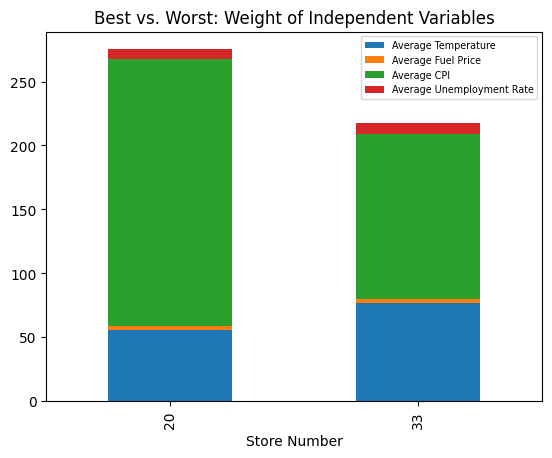

In [ ]:
bestWorstStore[["Average Temperature", "Average Fuel Price", "Average CPI", \
                "Average Unemployment Rate"]].plot(kind="bar",stacked=True)
plt.legend(fontsize ="x-small")
plt.title("Best vs. Worst: Scale of Independent Variables")
plt.xlabel("Store Number")
plt.show()

Through plotting bar graphs for the dependent variables on average of the best and worst store. The worst store conveys a higher temperature, fuel price and unemployment. The best store, on the other hand, conveys a higher CPI. 

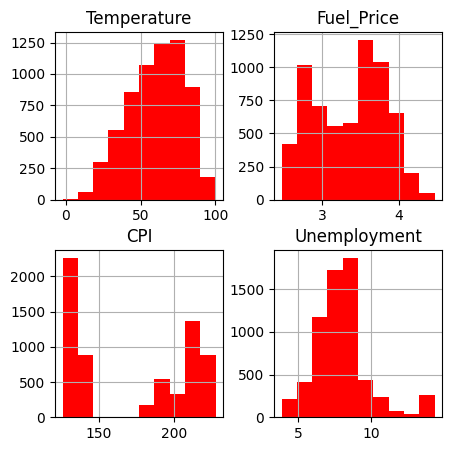

In [ ]:
storeData.hist(column = ["Temperature", "Fuel_Price","CPI", \
                         "Unemployment"],figsize=(5,5),color="Red")
plt.show()

Temperature and unemployment data show a normal distribution. Fuel Price and CPI, however do not. The reason for the nonnormal distribution of CPI is due to economic instability as shown by the two clusters in the CPI histogram. Fuel Price also has a nonnormal distribution due to the fluctuation of the oil prices.

In [ ]:
storeData = storeData.drop("Year",axis = 1)
storeData = storeData.drop("Month",axis = 1)
storeData = storeData.drop("Date",axis = 1)

print("Original Data\n")
print(storeData.head())
print("\n\n\nNormalized Data\n")


def normalizeData(dataToNormalize):

    dataToNormalize["Holiday_Flag"] = dataToNormalize["Holiday_Flag"].astype("bool")
    columnToNormalize = dataToNormalize[["Temperature", "Fuel_Price", "CPI", "Unemployment"]]
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(columnToNormalize)
    dataToNormalize[["Temperature", "Fuel_Price", "CPI", "Unemployment"]] = scaledData
 
    return dataToNormalize

normalizedData = normalizeData(storeData)
print(normalizedData.head())

Original Data

  Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0     1    1643690.90         False        42.31       2.572  211.096358   
1     1    1641957.44          True        38.51       2.548  211.242170   
2     1    1611968.17         False        39.93       2.514  211.289143   
3     1    1409727.59         False        46.63       2.561  211.319643   
4     1    1554806.68         False        46.50       2.625  211.350143   

   Unemployment  
0         8.106  
1         8.106  
2         8.106  
3         8.106  
4         8.106  



Normalized Data

  Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price       CPI  \
0     1    1643690.90         False     0.434149    0.050100  0.840500   
1     1    1641957.44          True     0.396967    0.038076  0.841941   
2     1    1611968.17         False     0.410861    0.021042  0.842405   
3     1    1409727.59         False     0.476419    0.044589  0.842707   
4     1    1554806.68         

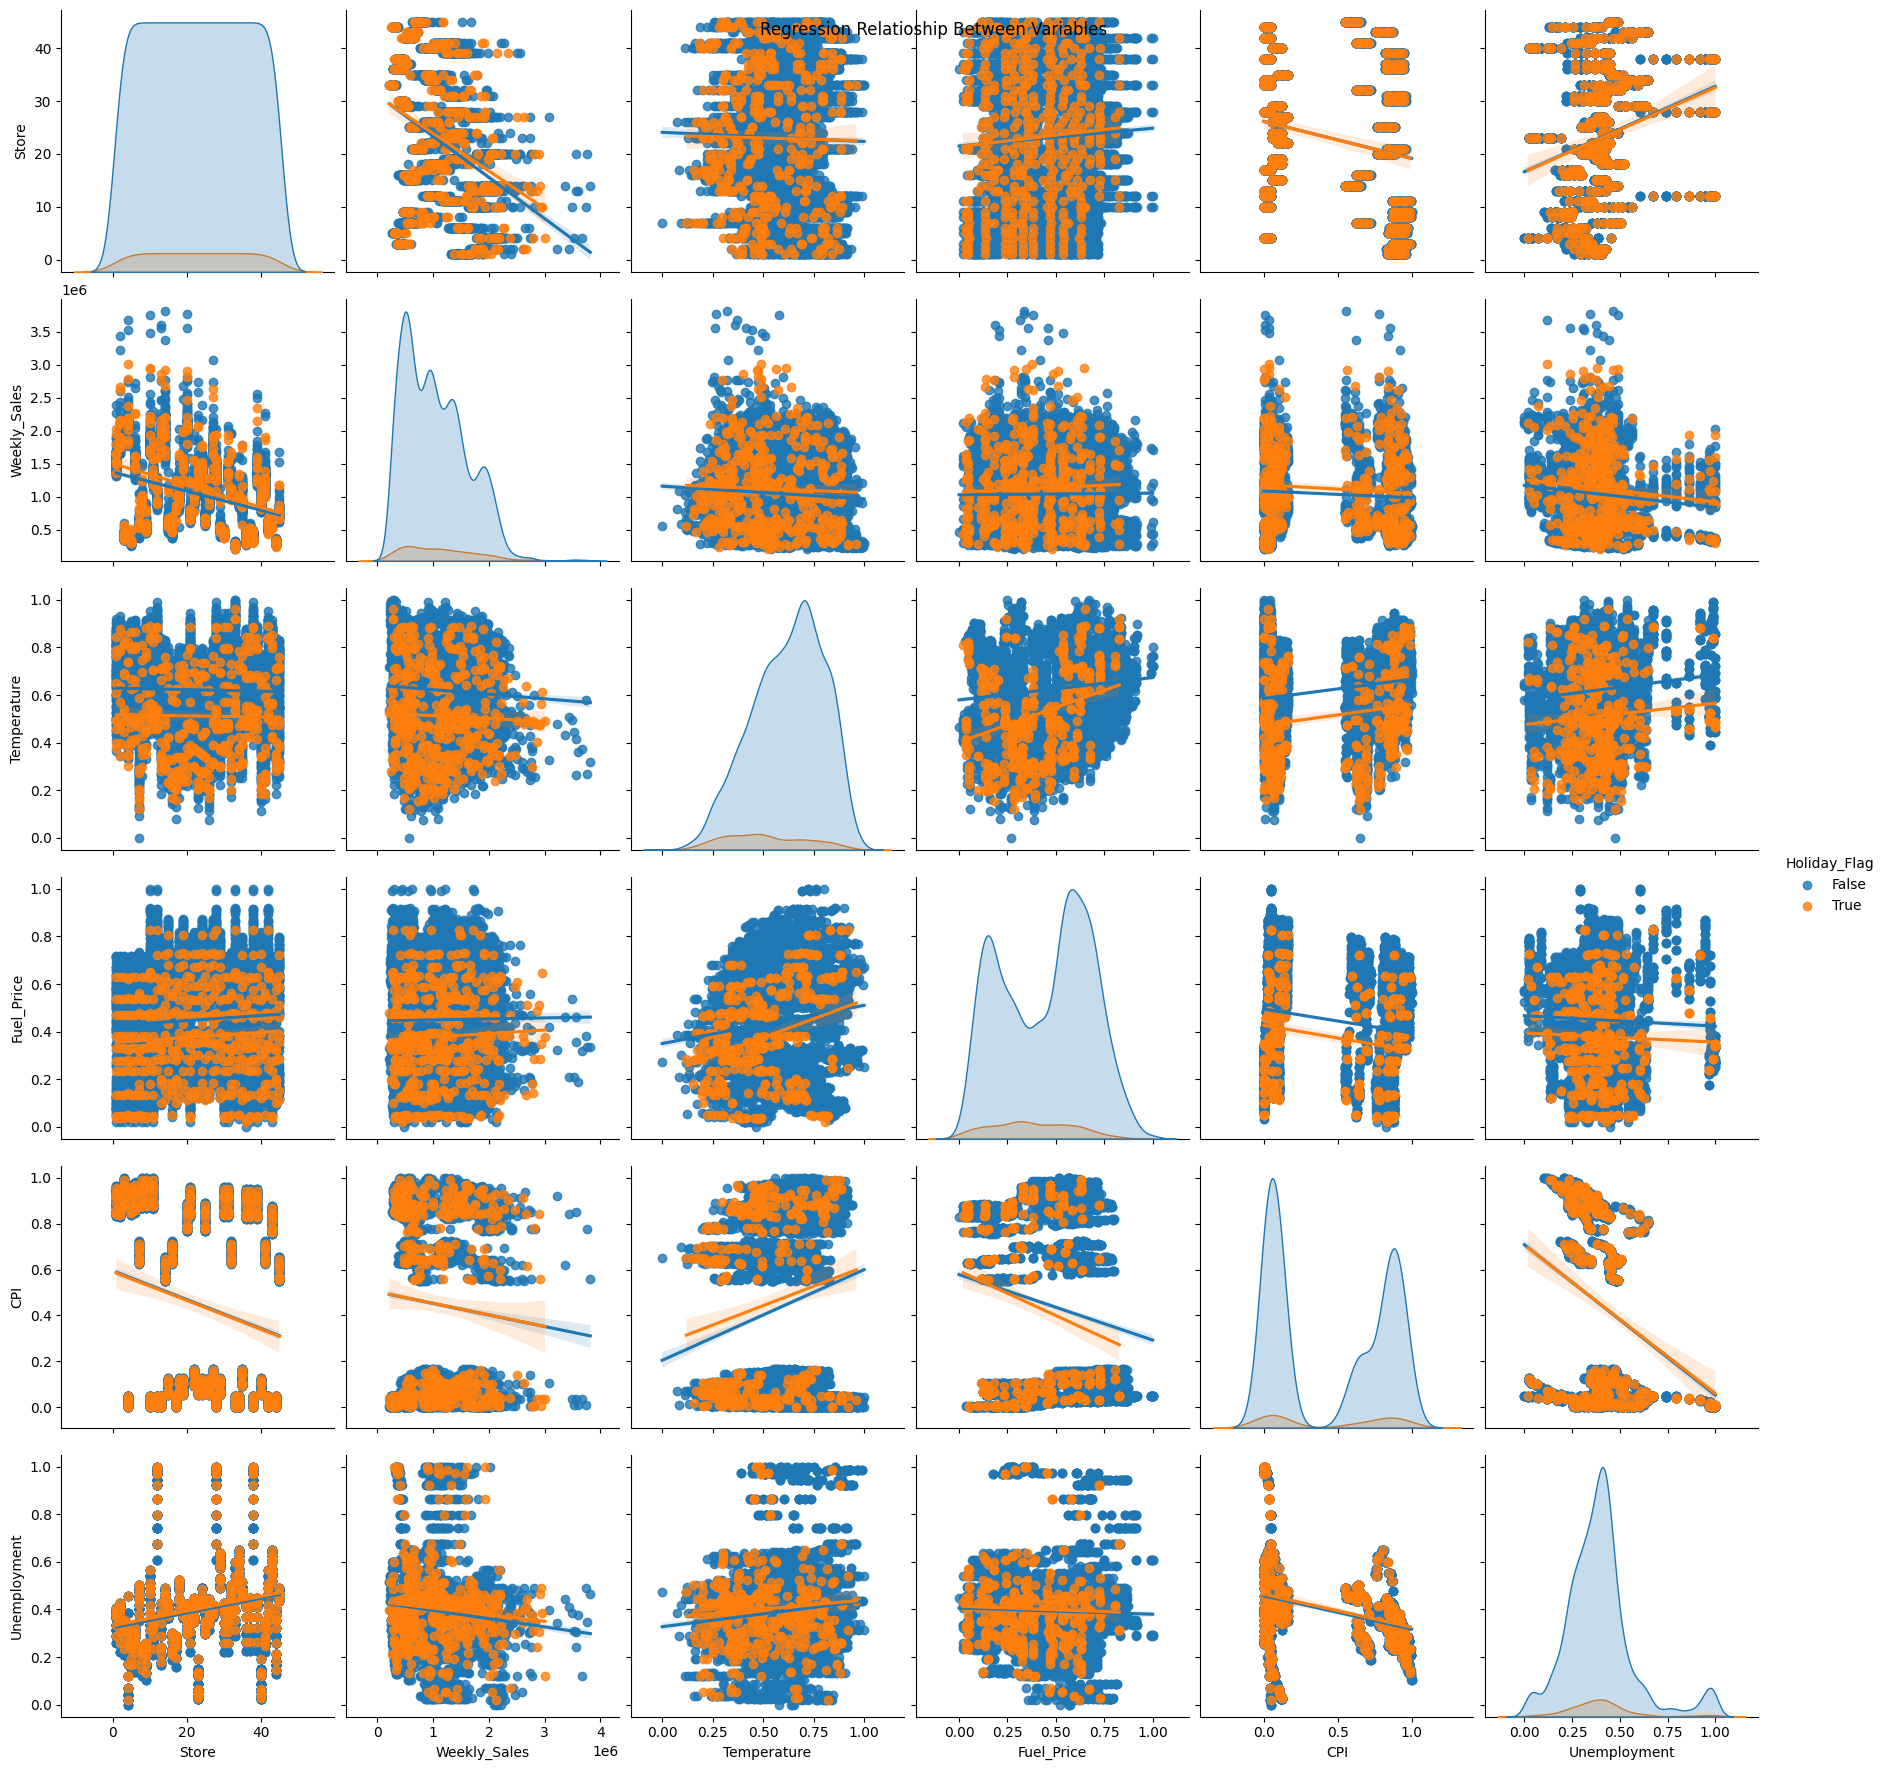

In [ ]:
pairplotFigure = sns.pairplot(data=normalizedData,\
                      height=3,kind="reg",hue = "Holiday_Flag")

pairplotFigure.fig.suptitle("Regression Relatioship Between Variables")
plt.show()

[Text(0.5, 1.0, 'Checking Multicollinearity')]

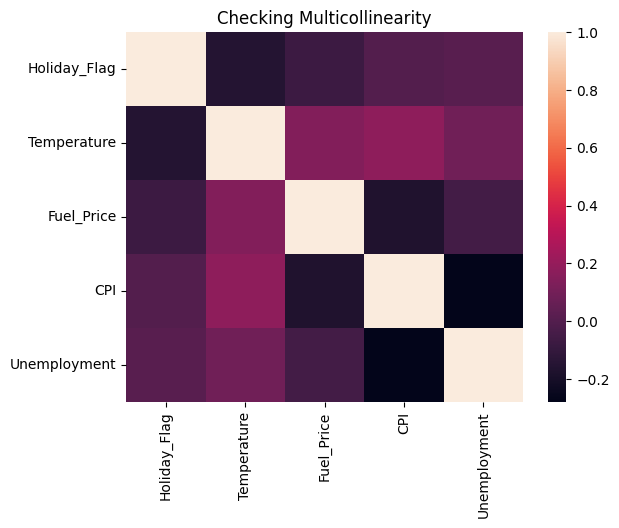

In [ ]:
sns.heatmap(normalizedData[["Holiday_Flag","Temperature","Fuel_Price","CPI",\
  "Unemployment"]].corr()).set(title="Checking Multicollinearity")

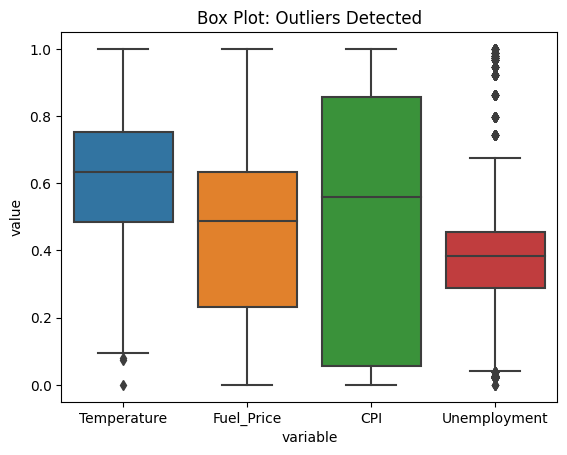

In [ ]:
sns.boxplot(x="variable", y="value",data=pd.melt(normalizedData[["Temperature",\
  "Fuel_Price","CPI","Unemployment"]])).set(title="Box Plot: Outliers Detected")

plt.show()

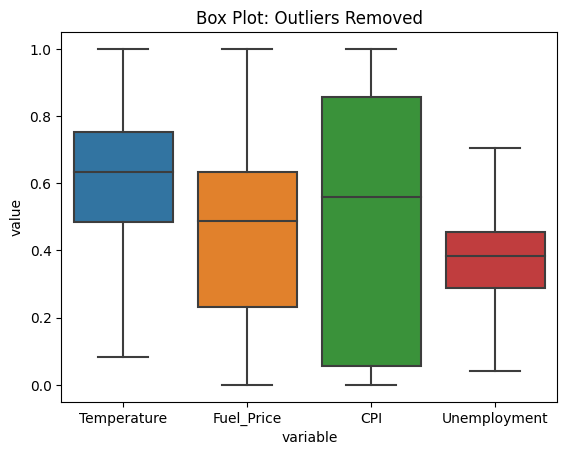

In [ ]:
def outliersRemoved(data, column):
    Q1 = np.percentile(data[column],25,method="midpoint")
    Q3 = np.percentile(data[column],75,method="midpoint")
    IQR = Q3 - Q1

    lowerbound = Q1 - 1.5 * IQR
    upperbound = Q3 + 1.5 * IQR
    
    data[column] = data[column].clip(lower=lowerbound, upper=upperbound)

    return data[column]

normalizedData["Unemployment"] = outliersRemoved(normalizedData,"Unemployment")
normalizedData["Temperature"] = outliersRemoved(normalizedData,"Temperature")

sns.boxplot(x="variable", y="value",data=pd.melt(normalizedData[["Temperature",\
  "Fuel_Price","CPI","Unemployment"]])).set(title="Box Plot: Outliers Removed")
plt.show()

Model selection

In [ ]:
storeData["Unemployment"] = outliersRemoved(storeData,"Unemployment")
storeData["Temperature"] = outliersRemoved(storeData,"Temperature")

In [ ]:
def trainTestSplit(data):
  data["Store"] = data["Store"].astype("category")
  x = data[["Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Store"]]
  y = data["Weekly_Sales"]
  x_train, x_test, y_train, y_test = train_test_split(x,y)
  return x_train, x_test, y_train, y_test, x, y

In [ ]:
def performance(y_predict, y_test):
  predict = pd.DataFrame({'Prediction': y_predict, 'Actual Value': y_test})
  predict['Error'] = predict['Actual Value'] - predict['Prediction']
  return predict

In [ ]:
def performOLSRegression(x_train, x_test, y_train, y_test, x, y):
  data = pd.concat([y_train, x_train], axis=1)
  olsModel = smf.ols(formula="Weekly_Sales ~ Store + Holiday_Flag + Temperature + \
          Fuel_Price + CPI + Unemployment",data=data).fit()
  y_predict = olsModel.predict(x_test)
  print(olsModel.summary())

  plt.scatter(y_test, y_predict)

  plt.title("Linear Regression Model")
  plt.xlabel("Actual Sales")
  plt.ylabel("Predicted Sales")

  a, b = np.polyfit(y_test,y_predict,1)
  plt.plot(y_test,a* y_test+ b, color = "Green")

  plt.show()

  meanSquaredError = mean_squared_error(y_test,y_predict)
  print('Mean squared error (MSE): %.2f' % meanSquaredError)
  print('RMSE: %.2f' % math.sqrt(meanSquaredError))
  
  return y_predict

In [ ]:
def performRandomForest(x_train, x_test, y_train, y_test, x, y):
    forest = RandomForestRegressor(n_estimators = 1000, max_depth = 7)
    forest.fit(x_train,y_train)

    y_predict = forest.predict(x_test)
    errors = abs(y_predict - y_test)

    mape = 100 * errors / y_test
    accuracy = 100 - np.mean(mape)

    meanSquaredError = mean_squared_error(y_test,y_predict)
    rSquared = r2_score(y_test,y_predict)
    adj_rSquared = 1 - (1-rSquared) * (len(y)-1)/(len(y)-x.shape[1]-1)

    print("Variance Score: ", forest.score(x_test,y_test))
    print('Mean squared error (MSE): %.2f' % meanSquaredError)
    print('RMSE: %.2f' % math.sqrt(meanSquaredError))
    print('Coefficient of Determination (R^2): %.2f' % rSquared)
    print('Adjusted R^2: %.2f' % adj_rSquared)

    plt.scatter(y_test, y_predict, color = "orange")
    plt.title("Random Forest Model")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")

    a, b = np.polyfit(y_test,y_predict,1)
    plt.plot(y_test,a* y_test+ b, color="Crimson")

    plt.show()
    
    return y_predict

In [ ]:
def norm(data):
  columnToNormalize = data[["Temperature", "Fuel_Price", "CPI", "Unemployment"]]
  scaler = MinMaxScaler()
  scaledData = scaler.fit_transform(columnToNormalize)
  data[["Temperature", "Fuel_Price", "CPI", "Unemployment"]] = scaledData
  return data

In [ ]:
def bc(data):
  data["Temperature"],_ = stats.boxcox(data["Temperature"])
  data["Fuel_Price"],_ = stats.boxcox(data["Fuel_Price"])
  data["CPI"],_ = stats.boxcox(data["CPI"])
  data["Unemployment"],_ = stats.boxcox(data["Unemployment"])
  return data

In [ ]:
storeData = storeData.drop("Year",axis = 1)
storeData = storeData.drop("Month",axis = 1)
storeData = storeData.drop("Date",axis = 1)

In [ ]:
x_train, x_test, y_train, y_test, x, y = trainTestSplit(storeData)

In [ ]:
x_train.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Store
18,False,80.43,2.668,211.456095,7.808,1
4249,False,52.21,3.268,219.625842,7.057,30
1915,False,38.65,3.433,184.387991,8.549,14
537,False,50.38,3.619,130.645793,4.607,4
3693,False,47.11,3.947,138.088267,7.489,26


In [ ]:
x_train_norm.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Store
18,False,0.790096,0.098196,0.844056,0.507438,1
4249,False,0.489563,0.398798,0.924809,0.398975,30
1915,False,0.345154,0.481463,0.576502,0.614457,14
537,False,0.470075,0.574649,0.045289,0.045133,4
3693,False,0.435250,0.738978,0.118853,0.461366,26


In [ ]:
x_train_bc.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Store
18,False,216.496812,1.832371,3.879138,4.910334,1
4249,False,124.007439,2.548778,3.898235,4.453146,30
1915,False,84.051682,2.749770,3.809359,5.350870,14
537,False,118.422244,2.978238,3.628346,2.865950,4
3693,False,108.585581,3.385771,3.657992,4.717529,26


OLS linear model

original dataset

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1098.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:27:16   Log-Likelihood:                -64740.
No. Observations:                4826   AIC:                         1.296e+05
Df Residuals:                    4776   BIC:                         1.299e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.456e+06 

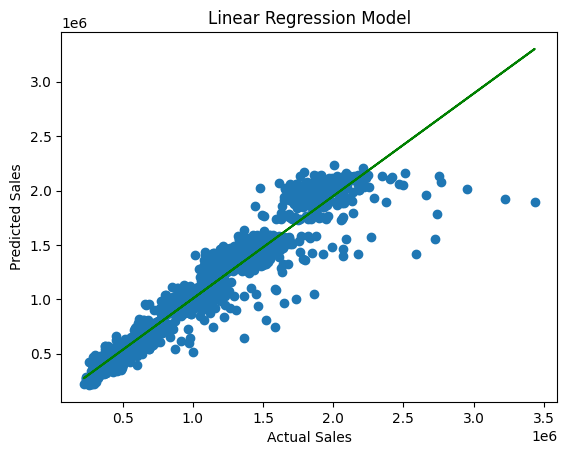

Mean squared error (MSE): 23373412612.57
RMSE: 152883.66


In [ ]:
y_predict = performOLSRegression(x_train, x_test, y_train, y_test, x, y)

In [ ]:
y_performance = performance(y_predict, y_test)
y_performance.head()

,Prediction,Actual Value,Error
2873,7.241464e+05,744969.42,20822.990242
5438,1.461961e+06,1266254.21,-195706.770331
3262,1.386013e+06,1277758.76,-108254.615537
1359,1.896076e+06,1711813.13,-184263.350926
5301,3.989516e+05,337723.49,-61228.131490


normalized dataset

In [ ]:
x_train_norm = x_train.copy()
x_train_norm = norm(x_train_norm)
x_test_norm = x_test.copy()
x_test_norm = norm(x_test_norm)

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1098.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:27:23   Log-Likelihood:                -64740.
No. Observations:                4826   AIC:                         1.296e+05
Df Residuals:                    4776   BIC:                         1.299e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.523e+06 

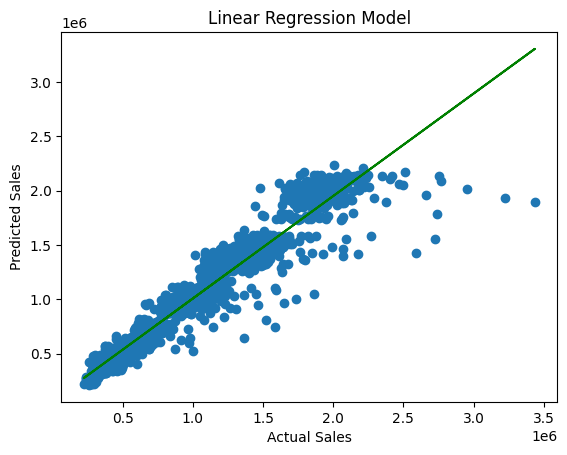

Mean squared error (MSE): 23386850432.95
RMSE: 152927.60


In [ ]:
y_predict = performOLSRegression(x_train_norm, x_test_norm, y_train, y_test, x, y)

In [ ]:
y_performance = performance(y_predict, y_test)
y_performance.head()

,Prediction,Actual Value,Error
2873,7.253575e+05,744969.42,19611.926922
5438,1.464402e+06,1266254.21,-198148.010674
3262,1.387480e+06,1277758.76,-109721.051540
1359,1.895288e+06,1711813.13,-183475.073619
5301,4.001131e+05,337723.49,-62389.561551


box-cox dataset

In [ ]:
x_train_bc = x_train.copy()
x_train_bc = bc(x_train_bc)
x_test_bc = x_test.copy()
x_test_bc = bc(x_test_bc)

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1099.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:37:12   Log-Likelihood:                -64738.
No. Observations:                4826   AIC:                         1.296e+05
Df Residuals:                    4776   BIC:                         1.299e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.255e+06 

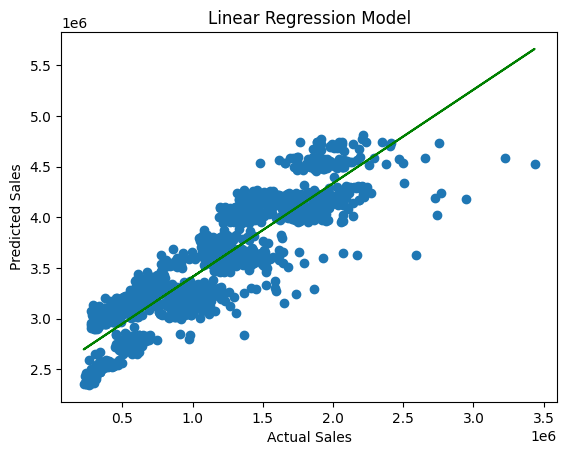

Mean squared error (MSE): 5869026881699.55
RMSE: 2422607.46


In [ ]:
y_predict = performOLSRegression(x_train_bc, x_test_bc, y_train, y_test, x, y)

In [ ]:
y_performance = performance(y_predict, y_test)
y_performance.head()

,Prediction,Actual Value,Error
2873,3.343564e+06,744969.42,-2.598595e+06
5438,4.092086e+06,1266254.21,-2.825832e+06
3262,3.601089e+06,1277758.76,-2.323330e+06
1359,4.043848e+06,1711813.13,-2.332035e+06
5301,2.556797e+06,337723.49,-2.219073e+06


Tree Model

Variance Score:  0.878680932608734
Mean squared error (MSE): 37258315885.43
RMSE: 193024.13
Coefficient of Determination (R^2): 0.88
Adjusted R^2: 0.88


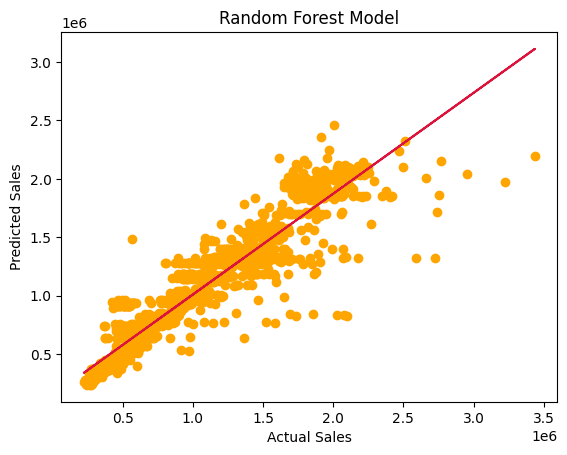

In [ ]:
y_predict = performRandomForest(x_train, x_test, y_train, y_test, x, y)

In [ ]:
y_performance = performance(y_predict, y_test)
y_performance.head()

,Prediction,Actual Value,Error
2873,7.547344e+05,744969.42,-9765.007747
5438,1.397019e+06,1266254.21,-130764.439744
3262,1.323172e+06,1277758.76,-45413.225035
1359,1.915977e+06,1711813.13,-204163.814127
5301,3.499467e+05,337723.49,-12223.233246
